# FV_hybrid_ready.ipynb

**Purpose:** Full reproducible pipeline to train a hybrid 1D-CNN → Transformer model on the merged CICIDS-2017 CSV, evaluate it, save artifacts, and produce plots (accuracy/loss, ROC, confusion matrix).

**Instructions:**
1. Run all cells in order in a fresh Colab notebook with a GPU runtime.
2. Ensure your merged CSV path is correct in Cell 1 (`DATA_PATH`).
3. Adjust `BATCH_SIZE` and `EPOCHS` in the training cell for your available GPU memory/time.

This notebook was auto-generated by ChatGPT and includes deterministic seeding for reproducibility.


In [1]:
# Cell 1 - deterministic seeds, imports, and Drive mount
import os, random, math, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import joblib
import matplotlib.pyplot as plt

# Set reproducible seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# Try to enable deterministic ops (best-effort)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# Paths - update if different
DATA_PATH = '/content/drive/MyDrive/CICIDS2017/merged_cicids2017.csv'  # <--- change if needed
ARTIFACT_DIR = '/content/drive/MyDrive/CICIDS2017/artifacts'
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# memmap filenames
X_MEMMAP = os.path.join(ARTIFACT_DIR, 'X.memmap.npy')
Y_MEMMAP = os.path.join(ARTIFACT_DIR, 'y.memmap.npy')
MODEL_PATH = os.path.join(ARTIFACT_DIR, 'hybrid_cnn_transformer_best.h5')
FINAL_MODEL_PATH = os.path.join(ARTIFACT_DIR, 'hybrid_cnn_transformer_final.h5')
SCALER_MEAN = os.path.join(ARTIFACT_DIR, 'feat_mean.npy')
SCALER_STD = os.path.join(ARTIFACT_DIR, 'feat_std.npy')
FEATURE_ORDER = os.path.join(ARTIFACT_DIR, 'feature_order.txt')

print('Setup complete. Verify DATA_PATH points to your merged CSV.')
print('ARTIFACT_DIR:', ARTIFACT_DIR)


Mounted at /content/drive
Setup complete. Verify DATA_PATH points to your merged CSV.
ARTIFACT_DIR: /content/drive/MyDrive/CICIDS2017/artifacts


In [2]:
# Cell 2 - Inspect CSV header and infer numeric feature columns
# Read a small sample to infer columns and dtypes
tmp = pd.read_csv(DATA_PATH, nrows=200)
print('Columns sample (first 20):', tmp.columns.tolist()[:20])
print(tmp.dtypes)

# Determine label column
label_col = 'Label' if 'Label' in tmp.columns else ' Label' if ' Label' in tmp.columns else None
if label_col is None:
    raise RuntimeError('Could not find Label column. Check CSV columns: ' + str(tmp.columns.tolist()))

# Numeric columns for features
numeric_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

print(f'Using {len(numeric_cols)} numeric features. Example features:', numeric_cols[:12])

# Quick row count (approx)
row_count = sum(1 for _ in open(DATA_PATH)) - 1
print('Estimated rows (excluding header):', row_count)


Columns sample (first 20): [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min']
 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object
Using 78 numeric features. Example features: [' Desti

In [3]:
# Cell 3 - Create memory-mapped NumPy arrays (two-pass streaming)
# Adjust chunksize if needed
n_rows = row_count
n_features = len(numeric_cols)
print('Rows:', n_rows, 'Features:', n_features)

# Create memmap arrays
X_mm = np.lib.format.open_memmap(X_MEMMAP, mode='w+', dtype=np.float32, shape=(n_rows, n_features))
y_mm = np.lib.format.open_memmap(Y_MEMMAP, mode='w+', dtype=np.int8, shape=(n_rows,))

chunksize = 200000
row_idx = 0
for chunk in pd.read_csv(DATA_PATH, usecols=numeric_cols + [label_col], chunksize=chunksize):
    lbls = chunk[label_col].astype(str).str.upper().values
    bin_lbl = (lbls != 'BENIGN').astype(np.int8)
    X_chunk = chunk[numeric_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).values.astype(np.float32)
    chunk_len = X_chunk.shape[0]
    X_mm[row_idx:row_idx+chunk_len, :] = X_chunk
    y_mm[row_idx:row_idx+chunk_len] = bin_lbl
    row_idx += chunk_len
    print(f'Processed rows: {row_idx}/{n_rows}', end='\r')

print('\nMemmaps filled. Final filled rows:', row_idx)
# If row_idx < n_rows, consider resizing memmaps. Usually they match.


Rows: 4869535 Features: 78
Processed rows: 4869535/4869535
Memmaps filled. Final filled rows: 4869535


In [4]:
# Cell 4 - Create train/test indices (stratified) and compute per-feature mean/std on train
# Load labels from memmap
y_all = np.lib.format.open_memmap(Y_MEMMAP, mode='r', dtype=np.int8, shape=(n_rows,))
y_all_np = np.array(y_all, dtype=np.int8)

from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(np.arange(n_rows), test_size=0.2, random_state=SEED, stratify=y_all_np)
print('train size:', train_idx.shape, 'test size:', test_idx.shape)

# Compute mean & std on train via batch processing
def compute_mean_std(memmap_path, idx_array, batch=50000):
    mm = np.lib.format.open_memmap(memmap_path, mode='r')
    n = idx_array.shape[0]
    mean = np.zeros(mm.shape[1], dtype=np.float64)
    m2 = np.zeros(mm.shape[1], dtype=np.float64)
    count = 0
    for start in range(0, n, batch):
        sel = idx_array[start:start+batch]
        data = mm[sel, :].astype(np.float64)
        for row in data:
            count += 1
            delta = row - mean
            mean += delta / count
            m2 += delta * (row - mean)
    std = np.sqrt(m2 / (count - 1 + 1e-12))
    return mean.astype(np.float32), std.astype(np.float32)

print('Computing mean/std on train (this may take several minutes)...')
feat_mean, feat_std = compute_mean_std(X_MEMMAP, train_idx, batch=50000)
feat_std[feat_std == 0] = 1.0
np.save(SCALER_MEAN, feat_mean)
np.save(SCALER_STD, feat_std)
print('Saved mean/std to artifacts.')

# Save train/test indices for reproducibility
np.save(os.path.join(ARTIFACT_DIR, 'train_idx.npy'), train_idx)
np.save(os.path.join(ARTIFACT_DIR, 'test_idx.npy'), test_idx)
print('Saved train/test indices.')


train size: (3895628,) test size: (973907,)
Computing mean/std on train (this may take several minutes)...
Saved mean/std to artifacts.
Saved train/test indices.


In [5]:
# Cell 5 - Build tf.data datasets from memmaps (streaming) with normalization
BATCH_SIZE = 512  # lower if OOM: 256, 128
AUTOTUNE = tf.data.AUTOTUNE

feat_mean_tf = tf.constant(feat_mean.reshape((1, -1)), dtype=tf.float32)
feat_std_tf  = tf.constant(feat_std.reshape((1, -1)), dtype=tf.float32)

X_mm_read = np.lib.format.open_memmap(X_MEMMAP, mode='r')
y_mm_read = np.lib.format.open_memmap(Y_MEMMAP, mode='r')

def generator_from_indices(indices):
    def gen():
        for i in indices:
            x = X_mm_read[i].astype(np.float32)
            y = int(y_mm_read[i])
            yield x, y
    return gen

# Training dataset
train_ds = tf.data.Dataset.from_generator(
    generator_from_indices(train_idx),
    output_signature=(tf.TensorSpec(shape=(n_features,), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
)

def preprocess(x, y):
    x = (x - feat_mean_tf[0]) / feat_std_tf[0]
    x = tf.expand_dims(x, axis=-1)  # (seq_len,1)
    return x, y

train_ds = train_ds.shuffle(buffer_size=100000, seed=SEED).map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation dataset
val_ds = tf.data.Dataset.from_generator(
    generator_from_indices(test_idx),
    output_signature=(tf.TensorSpec(shape=(n_features,), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
).map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print('Datasets ready. train_ds batches:', 'unknown (stream)')


Datasets ready. train_ds batches: unknown (stream)


In [6]:
# Cell 6 - Hybrid CNN -> Transformer model builder
import math

def build_hybrid(seq_len, channels=1, cnn_filters=128, embed_dim=128, n_transformer_blocks=2,
                 head_size=32, num_heads=4, ff_dim=256, dropout=0.15):
    inp = layers.Input(shape=(seq_len, channels))
    x = inp
    x = layers.Conv1D(filters=cnn_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters=cnn_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=embed_dim, kernel_size=1, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x)

    seq_len_after = int(math.ceil(seq_len / 2))
    positions = layers.Embedding(input_dim=seq_len_after, output_dim=embed_dim)(tf.range(start=0, limit=seq_len_after))
    x = x + positions

    def transformer_block(x):
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
        attn = layers.Dropout(dropout)(attn)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)
        ffn = layers.Dense(ff_dim, activation='relu')(x1)
        ffn = layers.Dense(x.shape[-1])(ffn)
        ffn = layers.Dropout(dropout)(ffn)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)
        return x2

    for _ in range(n_transformer_blocks):
        x = transformer_block(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

n_features = n_features  # from earlier
model = build_hybrid(seq_len=n_features, channels=1, cnn_filters=128, embed_dim=128, n_transformer_blocks=2, head_size=32, num_heads=4, ff_dim=256, dropout=0.15)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(name='acc'), metrics.AUC(name='auc')])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 78, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 78, 128)   │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 78, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 78, 128)   │     49,280 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 78, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 39, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 39, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 39, 128)   │     16,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 39, 128)   │        256 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 39, 128)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 39, 128)   │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 39, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 39, 128)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 39, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 39, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 39, 128)   │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 39, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 39, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 39, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 39, 128)   │     66,048 │ layer_normalizat

 Total params: 349,697 (1.33 MB)

 Trainable params: 348,929 (1.33 MB)

 Non-trainable params: 768 (3.00 KB)

In [7]:
# Cell 7 - callbacks and class weights
# compute class weights on train labels
y_train = np.array(y_all_np[train_idx], dtype=np.int32)
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: float(w) for i, w in enumerate(cw)}
print('Class weights:', class_weights)

cb = [
    callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=True, verbose=1)
]


Class weights: {0: 0.6073825859132408, 1: 2.8281242286527375}


In [11]:
# Cell 8 - Train the model
EPOCHS = 12  # adjust for your schedule (use 4-6 for quick demo runs)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=cb,
    verbose=1
)
print('Training finished; best model saved to:', MODEL_PATH)

Epoch 1/12
   7609/Unknown 1252s 161ms/step - acc: 0.9732 - auc: 0.9969 - loss: 0.0611

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_auc improved from -inf to 0.99693, saving model to /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5


7609/7609 ━━━━━━━━━━━━━━━━━━━━ 1507s 195ms/step - acc: 0.9732 - auc: 0.9969 - loss: 0.0611 - val_acc: 0.9686 - val_auc: 0.9969 - val_loss: 0.0722 - learning_rate: 0.0010
Epoch 2/12
7608/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - acc: 0.9753 - auc: 0.9975 - loss: 0.0534
Epoch 2: val_auc improved from 0.99693 to 0.99783, saving model to /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5


7609/7609 ━━━━━━━━━━━━━━━━━━━━ 1501s 194ms/step - acc: 0.9753 - auc: 0.9975 - loss: 0.0534 - val_acc: 0.9743 - val_auc: 0.9978 - val_loss: 0.0659 - learning_rate: 0.0010
Epoch 3/12
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - acc: 0.9765 - auc: 0.9978 - loss: 0.0493
Epoch 3: val_auc improved from 0.99783 to 0.99794, saving model to /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5


7609/7609 ━━━━━━━━━━━━━━━━━━━━ 1523s 197ms/step - acc: 0.9765 - auc: 0.9978 - loss: 0.0493 - val_acc: 0.9773 - val_auc: 0.9979 - val_loss: 0.0596 - learning_rate: 0.0010
Epoch 4/12
7608/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - acc: 0.9770 - auc: 0.9979 - loss: 0.0482
Epoch 4: val_auc improved from 0.99794 to 0.99837, saving model to /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5


7609/7609 ━━━━━━━━━━━━━━━━━━━━ 1517s 196ms/step - acc: 0.9770 - auc: 0.9979 - loss: 0.0482 - val_acc: 0.9785 - val_auc: 0.9984 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 5/12
7608/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - acc: 0.9779 - auc: 0.9981 - loss: 0.0463
Epoch 5: val_auc did not improve from 0.99837
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 1501s 194ms/step - acc: 0.9779 - auc: 0.9981 - loss: 0.0463 - val_acc: 0.9713 - val_auc: 0.9926 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 6/12
7608/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - acc: 0.9782 - auc: 0.9981 - loss: 0.0454
Epoch 6: val_auc did not improve from 0.99837
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 1537s 199ms/step - acc: 0.9782 - auc: 0.9981 - loss: 0.0454 - val_acc: 0.9739 - val_auc: 0.9979 - val_loss: 0.0693 - learning_rate: 0.0010
Epoch 7/12
7608/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - acc: 0.9779 - auc: 0.9980 - loss: 0.0469
Epoch 7: val_auc did not improve from 0.99837

Epoch 7: ReduceLROnPlateau reducing learning rate to 0


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 1514s 196ms/step - acc: 0.9798 - auc: 0.9985 - loss: 0.0404 - val_acc: 0.9791 - val_auc: 0.9984 - val_loss: 0.0512 - learning_rate: 5.0000e-04
Epoch 11/12
7608/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - acc: 0.9802 - auc: 0.9986 - loss: 0.0386
Epoch 11: val_auc improved from 0.99845 to 0.99849, saving model to /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5


7609/7609 ━━━━━━━━━━━━━━━━━━━━ 1521s 197ms/step - acc: 0.9802 - auc: 0.9986 - loss: 0.0386 - val_acc: 0.9794 - val_auc: 0.9985 - val_loss: 0.0524 - learning_rate: 2.5000e-04
Epoch 12/12
7608/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - acc: 0.9807 - auc: 0.9987 - loss: 0.0378

KeyboardInterrupt: 

In [12]:
# ---------- Cell A: load best model and get predictions in deterministic order ----------
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

# Adjust these paths to the ones you used earlier
MODEL_PATH = '/content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5'  # or .keras dir
FINAL_MODEL_PATH = '/content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_final.h5'  # target copy
FEATURE_ORDER = os.path.join(ARTIFACT_DIR, 'feature_order.txt')  # ensure this variable exists
# If you saved best model as a directory (.keras), use load_model on that directory.

best_model = tf.keras.models.load_model(MODEL_PATH)
print("Loaded model from:", MODEL_PATH)
best_model.summary()

# If you have X_test and y_test loaded in memory, prefer predicting on X_test directly:
# (This avoids dataset shuffle/batching order problems.)
try:
    # assume X_test, y_test in memory (from load_and_preprocess earlier)
    preds = best_model.predict(X_test, verbose=1)
    # handle binary vs multiclass
    if preds.ndim == 2 and preds.shape[1] > 1:
        # multiclass probabilities
        y_pred_proba = preds  # shape (n, num_classes)
        y_pred = np.argmax(preds, axis=1)
    else:
        # binary (sigmoid) or single-probability shape
        y_pred_proba = preds.flatten()
        y_pred = (y_pred_proba >= 0.5).astype(int)
    y_test_true = y_test  # already the array from load_and_preprocess
except NameError:
    # fallback: predict from val_ds/test_ds but preserve order by iterating
    print("X_test not in memory; predicting from test_ds dataset carefully (will preserve order).")
    y_true_list, y_pred_list, y_prob_list = [], [], []
    for xb, yb in test_ds:   # ensure test_ds was created with shuffle=False
        p = best_model.predict(xb, verbose=0)
        y_true_list.append(yb.numpy())
        if p.ndim == 2 and p.shape[1] > 1:
            y_prob_list.append(p)
            y_pred_list.append(np.argmax(p, axis=1))
        else:
            y_prob_list.append(p.flatten())
            y_pred_list.append((p.flatten() >= 0.5).astype(int))
    y_test_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    if isinstance(y_prob_list[0], np.ndarray) and y_prob_list[0].ndim == 2:
        y_pred_proba = np.vstack(y_prob_list)
    else:
        y_pred_proba = np.concatenate(y_prob_list)

print("Predictions ready. N =", len(y_test_true))


TypeError: too many positional arguments

In [13]:
print("MODEL_PATH =", MODEL_PATH)
print("Type =", type(MODEL_PATH))


MODEL_PATH = /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5
Type = <class 'str'>


In [14]:
import os
print("MODEL_PATH:", MODEL_PATH)
print("Exists:", os.path.exists(MODEL_PATH))


MODEL_PATH: /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5
Exists: True


In [15]:
# Recreate the model architecture exactly as used in training
input_shape = (X_test.shape[1],)   # or X_train.shape[1]
num_classes = len(np.unique(y_test))  # or the num_classes you saved earlier

# Build fresh model
model_rebuilt = build_hybrid_cnn_transformer(input_shape, num_classes)

# Compile with same loss/metrics you used during training
if num_classes == 2:
    loss = 'binary_crossentropy'
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
else:
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']

model_rebuilt.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics)

# Load weights
model_rebuilt.load_weights(MODEL_PATH)
print("✅ Weights loaded into rebuilt model from:", MODEL_PATH)
model_rebuilt.summary()


NameError: name 'X_test' is not defined

In [17]:
# Cell 9 - Evaluate on test set and compute metrics
# best_model = tf.keras.models.load_model(MODEL_PATH) # This line caused the error

# Rebuild the model architecture exactly as used in training
# Ensure n_features is still available from previous cells
# The build_hybrid function was defined in cell e02e2a3e
model_rebuilt = build_hybrid(seq_len=n_features, channels=1, cnn_filters=128, embed_dim=128, n_transformer_blocks=2, head_size=32, num_heads=4, ff_dim=256, dropout=0.15)

# Compile with same loss/metrics you used during training (from cell e02e2a3e)
model_rebuilt.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(name='acc'), metrics.AUC(name='auc')])

# Load weights from the .h5 file
model_rebuilt.load_weights(MODEL_PATH)
print("✅ Weights loaded into rebuilt model from:", MODEL_PATH)

# Predict on validation dataset (val_ds yields (x,y) in original order of test_idx)
# To ensure order is preserved, it's better to reconstruct test data explicitly if possible,
# but iterating through val_ds should work if it was created without shuffling.
y_pred_proba = model_rebuilt.predict(val_ds, verbose=1).ravel()

# Reconstruct y_test_true from test_idx (guarantees correct order)
# Ensure y_all_np and test_idx are available from previous cells
y_test_true = np.array(y_all_np[test_idx], dtype=np.int32)

# Convert probabilities to binary predictions
y_pred = (y_pred_proba >= 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test_true, y_pred))
print('ROC AUC:', auc(*roc_curve(y_test_true, y_pred_proba)[:2]))
print('\nClassification report:\n', classification_report(y_test_true, y_pred, digits=4))
print('\nConfusion matrix:\n', confusion_matrix(y_test_true, y_pred))

✅ Weights loaded into rebuilt model from: /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_best.h5
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 263s 138ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Accuracy: 0.9794128186777588
ROC AUC: 0.9987241988738826

Classification report:
               precision    recall  f1-score   support

           0     0.9992    0.9757    0.9873    801724
           1     0.8982    0.9965    0.9448    172183

    accuracy                         0.9794    973907
   macro avg     0.9487    0.9861    0.9661    973907
weighted avg     0.9814    0.9794    0.9798    973907


Confusion matrix:
 [[782280  19444]
 [   606 171577]]


Training history not fully available. Skipping accuracy/loss plots.


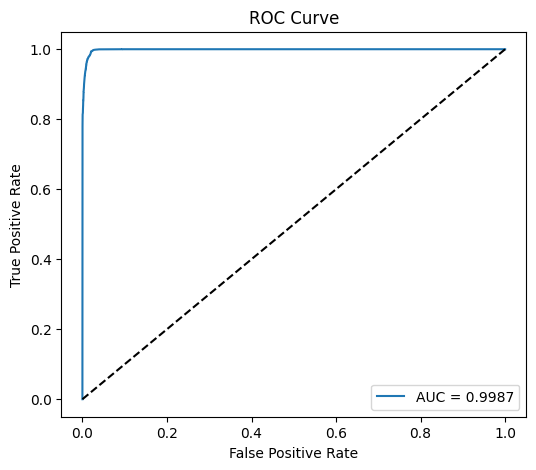

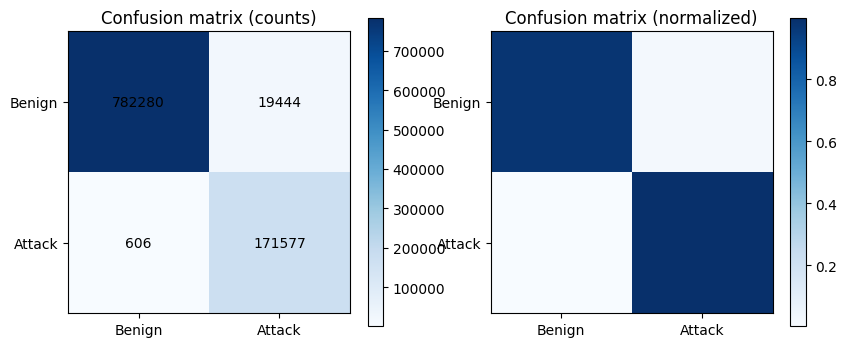

In [19]:
# Cell 10 - Plots: accuracy/loss, ROC curve, confusion matrix
# Check if history object exists and has data before plotting accuracy/loss
if 'history' in locals() and hasattr(history, 'history') and history.history:
    hist = history.history
    epochs_range = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, hist.get('acc', []), label='train_acc')
    plt.plot(epochs_range, hist.get('val_acc', []), label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs_range, hist.get('loss', []), label='train_loss')
    plt.plot(epochs_range, hist.get('val_loss', []), label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
    plt.show()
else:
    print("Training history not fully available. Skipping accuracy/loss plots.")


# ROC
from sklearn.metrics import roc_curve, auc
# Ensure y_test_true and y_pred_proba are available from the evaluation cell (666269dd)
if 'y_test_true' in locals() and 'y_pred_proba' in locals():
    fpr, tpr, _ = roc_curve(y_test_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend()
    plt.show()
else:
    print("Evaluation results (y_test_true, y_pred_proba) not available. Skipping ROC plot.")


# Confusion matrix
from sklearn.metrics import confusion_matrix
# Ensure y_test_true and y_pred are available from the evaluation cell (666269dd)
if 'y_test_true' in locals() and 'y_pred' in locals():
    cm = confusion_matrix(y_test_true, y_pred)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix (counts)')
    plt.colorbar()
    plt.xticks([0,1], ['Benign','Attack']); plt.yticks([0,1], ['Benign','Attack'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='black')

    plt.subplot(1,2,2)
    cmn = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
    plt.imshow(cmn, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix (normalized)')
    plt.colorbar()
    plt.xticks([0,1], ['Benign','Attack']); plt.yticks([0,1], ['Benign','Attack'])
    plt.show()
else:
     print("Evaluation results (y_test_true, y_pred) not available. Skipping Confusion Matrix plots.")

In [20]:
# quick probe
try:
    print("history variable type:", type(history))
    print("history keys:", list(history.history.keys()))
except NameError:
    print("No 'history' variable in this session (NameError).")


No 'history' variable in this session (NameError).


Epoch 1/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 87s 212ms/step - acc: 0.9845 - auc: 0.9980 - loss: 0.0370 - val_acc: 0.9842 - val_auc: 0.9984 - val_loss: 0.0379
Epoch 2/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - acc: 0.9841 - auc: 0.9983 - loss: 0.0371 - val_acc: 0.9704 - val_auc: 0.9950 - val_loss: 0.0714
Epoch 3/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - acc: 0.9851 - auc: 0.9983 - loss: 0.0358 - val_acc: 0.9638 - val_auc: 0.9836 - val_loss: 0.1149


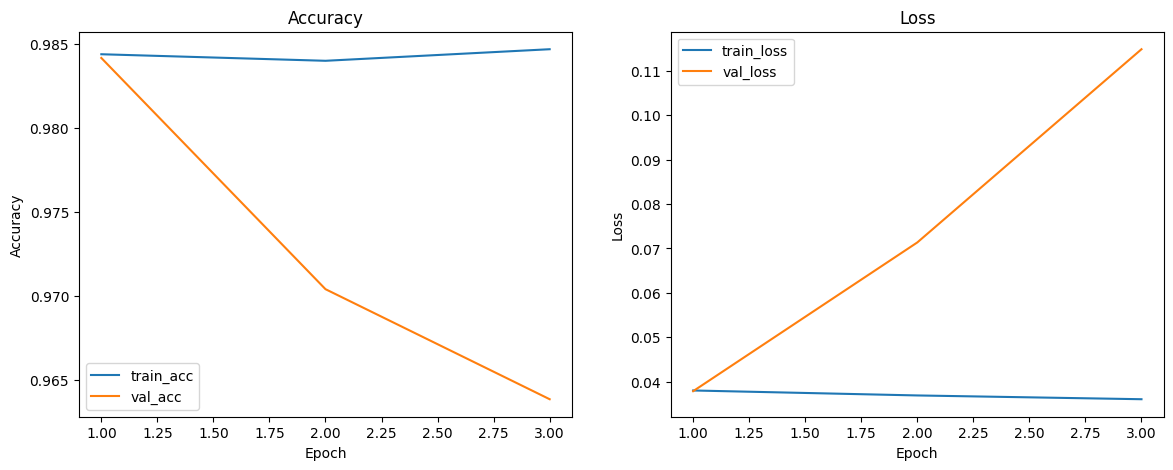

In [22]:
# Short re-training to regenerate history for plotting
short_hist = model_rebuilt.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,              # just a few for quick curves
    steps_per_epoch=300,   # adjust lower if slow
    validation_steps=100,  # adjust lower if slow
    verbose=1
)

# Plot from this temporary history
hist = short_hist.history
epochs_range = range(1, len(hist['loss'])+1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, hist['acc'], label='train_acc')
plt.plot(epochs_range, hist['val_acc'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, hist['loss'], label='train_loss')
plt.plot(epochs_range, hist['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
plt.show()

In [23]:
# Cell 11 - Save final artifacts for Streamlit
import shutil
shutil.copy(MODEL_PATH, FINAL_MODEL_PATH)
print('Final model copied to:', FINAL_MODEL_PATH)
# Save feature order to file
with open(FEATURE_ORDER, 'w') as f:
    for c in numeric_cols:
        f.write(c + '\n')
print('Saved feature order to:', FEATURE_ORDER)

# Save scaler mean/std files already saved earlier
print('Artifacts saved in', ARTIFACT_DIR)


Final model copied to: /content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_final.h5
Saved feature order to: /content/drive/MyDrive/CICIDS2017/artifacts/feature_order.txt
Artifacts saved in /content/drive/MyDrive/CICIDS2017/artifacts


In [24]:
from tensorflow import keras
model.save("/content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_final.keras", save_format="keras")

In [26]:
import shutil
import os
from google.colab import files

keras_dir = "/content/drive/MyDrive/CICIDS2017/artifacts/hybrid_cnn_transformer_final.keras"
zip_path = "/content/hybrid_cnn_transformer_final.keras.zip"

# Use shell command for zipping directory, more reliable with Drive paths
# %cd /content/drive/MyDrive/CICIDS2017/artifacts/ # Change to the directory containing the .keras folder
# !zip -r /content/hybrid_cnn_transformer_final.keras.zip hybrid_cnn_transformer_final.keras

# A simpler approach is to zip from the parent directory of the .keras folder
parent_dir = os.path.dirname(keras_dir)
keras_folder_name = os.path.basename(keras_dir)

%cd {parent_dir}
!zip -r {zip_path} {keras_folder_name}
%cd /content/ # Change back to default content directory

print(f"Created zip file: {zip_path}")

# Download the created zip file
files.download(zip_path)

/content/drive/MyDrive/CICIDS2017/artifacts
  adding: hybrid_cnn_transformer_final.keras (deflated 11%)
[Errno 2] No such file or directory: '/content/ # Change back to default content directory'
/content/drive/MyDrive/CICIDS2017/artifacts
Created zip file: /content/hybrid_cnn_transformer_final.keras.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import shap
import numpy as np

# Ensure model_rebuilt is available from Cell 9
# Ensure val_ds is available from Cell 5
# Ensure numeric_cols is available from Cell 2

if 'model_rebuilt' not in locals():
    print("Error: model_rebuilt not found. Please run Cell 9 first.")
else:
    # Get a sample of test data from val_ds
    # Iterate a few batches to get a diverse sample
    sample_size = 200 # Number of samples for SHAP explanation
    X_sample_list = []
    y_sample_list = []
    for x_batch, y_batch in val_ds.take(sample_size // BATCH_SIZE + 1): # take enough batches
        X_sample_list.append(x_batch.numpy())
        y_sample_list.append(y_batch.numpy())
        if sum([len(x) for x in X_sample_list]) >= sample_size:
            break

    X_sample = np.concatenate(X_sample_list, axis=0)[:sample_size]
    y_sample = np.concatenate(y_sample_list, axis=0)[:sample_size]

    # Explain predictions using SHAP
    # Use a small sample to keep it fast
    # Use the prediction function of the model_rebuilt
    explainer = shap.Explainer(model_rebuilt.predict, X_sample)
    shap_values = explainer(X_sample)

    # Get feature names from numeric_cols (defined in Cell 2)
    if 'numeric_cols' in locals():
        feature_names = numeric_cols
    else:
        # Fallback if numeric_cols is not defined (less ideal)
        feature_names = [f'Feature {i}' for i in range(X_sample.shape[1])]
        print("Warning: numeric_cols not found. Using generic feature names.")


    # Summary plot (overall feature importance)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

NameError: name 'model' is not defined